In [1]:
import pandas as pd
import catboost 
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense
from keras import backend as K
from keras import models
from keras import layers
from keras import regularizers
from keras import models
from keras import layers
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.ensemble import StackingClassifier
from sklearn.preprocessing import QuantileTransformer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import power_transform
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import shap
from sklearn.model_selection import cross_val_score
import pickle
from collections import Counter
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.metrics import roc_auc_score

from itertools import cycle

# opcje:
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 60)
pd.set_option('display.max_columns', None)

### Basics

In [2]:
df = pd.read_csv('../data/final_train.csv', index_col=0)

In [3]:
df

,Activity,"angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyAccMean,gravity)","angle(tBodyGyroJerkMean,gravityMean)","angle(tBodyGyroMean,gravityMean)",energy-mean(),"fBodyAcc-bandsEnergy()-1,16","fBodyAcc-bandsEnergy()-1,16.1","fBodyAcc-bandsEnergy()-1,16.2","fBodyAcc-bandsEnergy()-1,24","fBodyAcc-bandsEnergy()-1,24.1","fBodyAcc-bandsEnergy()-1,24.2","fBodyAcc-bandsEnergy()-1,8","fBodyAcc-bandsEnergy()-1,8.1","fBodyAcc-bandsEnergy()-1,8.2","fBodyAcc-bandsEnergy()-17,24","fBodyAcc-bandsEnergy()-17,24.1","fBodyAcc-bandsEnergy()-17,24.2","fBodyAcc-bandsEnergy()-17,32","fBodyAcc-bandsEnergy()-17,32.1","fBodyAcc-bandsEnergy()-17,32.2","fBodyAcc-bandsEnergy()-25,32","fBodyAcc-bandsEnergy()-25,32.1","fBodyAcc-bandsEnergy()-25,32.2","fBodyAcc-bandsEnergy()-25,48","fBodyAcc-bandsEnergy()-25,48.1","fBodyAcc-bandsEnergy()-25,48.2","fBodyAcc-bandsEnergy()-33,40","fBodyAcc-bandsEnergy()-33,40.1","fBodyAcc-bandsEnergy()-33,40.2","fBodyAcc-bandsEnergy()-33,48","fBodyAcc-bandsEnergy()-33,48.1","fBodyAcc-bandsEnergy()-33,48.2","fBodyAcc-bandsEnergy()-41,48","fBodyAcc-bandsEnergy()-41,48.1","fBodyAcc-bandsEnergy()-41,48.2","fBodyAcc-bandsEnergy()-49,56","fBodyAcc-bandsEnergy()-49,56.1","fBodyAcc-bandsEnergy()-49,56.2","fBodyAcc-bandsEnergy()-49,64","fBodyAcc-bandsEnergy()-49,64.1","fBodyAcc-bandsEnergy()-49,64.2","fBodyAcc-bandsEnergy()-57,64","fBodyAcc-bandsEnergy()-57,64.1","fBodyAcc-bandsEnergy()-57,64.2","fBodyAcc-bandsEnergy()-9,16","fBodyAcc-bandsEnergy()-9,16.1","fBodyAcc-bandsEnergy()-9,16.2",fBodyAcc-energy()-X,fBodyAcc-energy()-Y,fBodyAcc-energy()-Z,fBodyAcc-entropy()-X,fBodyAcc-entropy()-Y,fBodyAcc-entropy()-Z,fBodyAcc-iqr()-X,fBodyAcc-iqr()-Y,fBodyAcc-iqr()-Z,fBodyAcc-kurtosis()-X,fBodyAcc-kurtosis()-Y,fBodyAcc-kurtosis()-Z,fBodyAcc-mad()-X,fBodyAcc-mad()-Y,fBodyAcc-mad()-Z,fBodyAcc-main()-X,fBodyAcc-main()-Y,fBodyAcc-main()-Z,fBodyAcc-max()-X,fBodyAcc-max()-Y,fBodyAcc-max()-Z,fBodyAcc-maxInds-X,fBodyAcc-maxInds-Y,fBodyAcc-maxInds-Z,fBodyAcc-mean()-X,fBodyAcc-mean()-Y,fBodyAcc-mean()-Z,fBodyAcc-meanFreq()-X,fBodyAcc-meanFreq()-Y,fBodyAcc-meanFreq()-Z,fBodyAcc-min()-X,fBodyAcc-min()-Y,fBodyAcc-min()-Z,fBodyAcc-skewness()-X,fBodyAcc-skewness()-Y,fBodyAcc-skewness()-Z,fBodyAcc-sma(),fBodyAcc-std()-X,fBodyAcc-std()-Y,fBodyAcc-std()-Z,"fBodyAccJerk-bandsEnergy()-1,16","fBodyAccJerk-bandsEnergy()-1,16.1","fBodyAccJerk-bandsEnergy()-1,16.2","fBodyAccJerk-bandsEnergy()-1,24","fBodyAccJerk-bandsEnergy()-1,24.1","fBodyAccJerk-bandsEnergy()-1,24.2","fBodyAccJerk-bandsEnergy()-1,8","fBodyAccJerk-bandsEnergy()-1,8.1","fBodyAccJerk-bandsEnergy()-1,8.2","fBodyAccJerk-bandsEnergy()-17,24","fBodyAccJerk-bandsEnergy()-17,24.1","fBodyAccJerk-bandsEnergy()-17,24.2","fBodyAccJerk-bandsEnergy()-17,32","fBodyAccJerk-bandsEnergy()-17,32.1","fBodyAccJerk-bandsEnergy()-17,32.2","fBodyAccJerk-bandsEnergy()-25,32","fBodyAccJerk-bandsEnergy()-25,32.1","fBodyAccJerk-bandsEnergy()-25,32.2","fBodyAccJerk-bandsEnergy()-25,48","fBodyAccJerk-bandsEnergy()-25,48.1","fBodyAccJerk-bandsEnergy()-25,48.2","fBodyAccJerk-bandsEnergy()-33,40","fBodyAccJerk-bandsEnergy()-33,40.1","fBodyAccJerk-bandsEnergy()-33,40.2","fBodyAccJerk-bandsEnergy()-33,48","fBodyAccJerk-bandsEnergy()-33,48.1","fBodyAccJerk-bandsEnergy()-33,48.2","fBodyAccJerk-bandsEnergy()-41,48","fBodyAccJerk-bandsEnergy()-41,48.1","fBodyAccJerk-bandsEnergy()-41,48.2","fBodyAccJerk-bandsEnergy()-49,56","fBodyAccJerk-bandsEnergy()-49,56.1","fBodyAccJerk-bandsEnergy()-49,56.2","fBodyAccJerk-bandsEnergy()-49,64","fBodyAccJerk-bandsEnergy()-49,64.1","fBodyAccJerk-bandsEnergy()-49,64.2","fBodyAccJerk-bandsEnergy()-57,64","fBodyAccJerk-bandsEnergy()-57,64.1","fBodyAccJerk-bandsEnergy()-57,64.2","fBodyAccJerk-bandsEnergy()-9,16","fBodyAccJerk-bandsEnergy()-9,16.1","fBodyAccJerk-bandsEnergy()-9,16.2",fBodyAccJerk-energy()-X,fBodyAccJerk-energy()-Y,fBodyAccJerk-energy()-Z,fBodyAccJerk-entropy()-X,fBodyAccJerk-entropy()-Y,fBodyAccJerk-entropy()-Z,fBodyAc

In [4]:
df = df.drop_duplicates()

In [5]:
X, y = df.iloc[:,1:], df.iloc[:,0]

In [6]:
X.shape

(10975, 571)

In [7]:
y.value_counts()

LAYING                2117
SITTING               2006
STANDING              1977
WALKING               1897
WALKING_UPSTAIRS      1592
WALKING_DOWNSTAIRS    1386
Name: Activity, dtype: int64

In [8]:
def count_null_rows(data_frame):
    """
    Counting percentage of missing data by columns.
    """
    counter = (len(data_frame) - data_frame.count())
    percent = counter/len(data_frame) 
    frame = pd.concat([counter, percent], axis=1)
    frame = frame.rename(columns={0: 'r', 1: '%'})
    frame['%'] = round(frame['%']*100, 2)
    return frame.sort_values(by=frame.columns[0], ascending=False)

In [9]:
count_null_rows(X)

,r,%
"fBodyGyro-bandsEnergy()-33,48",84,0.77
"fBodyAcc-bandsEnergy()-49,56",79,0.72
tBodyAccMag-sma(),77,0.70
fBodyAccJerk-std()-Y,77,0.70
tBodyGyro-std()-X,76,0.69
...,...,...
fBodyBodyGyroJerkMag-min(),41,0.37
tGravityAcc-std()-X,40,0.36
fBodyAcc-main()-Z,39,0.36
fBodyAcc-entropy()-Y,38,0.35


In [10]:
pd.DataFrame.from_dict(Counter([col.split('-')[0].split('(')[0] for col in X.columns]), orient='index').rename(columns={0:'count'}).sort_values('count', ascending=False)

,count
fBodyAcc,82
fBodyGyro,79
fBodyAccJerk,79
tBodyGyro,43
tGravityAcc,40
tBodyAccJerk,40
tBodyAcc,40
tBodyGyroJerk,40
fBodyBodyGyroMag,13
tBodyGyroJerkMag,13


In [11]:
X["void()"].unique()

array([ 1.,  2.,  3., nan])

As we can see void() is almost uniformly distributed for some of the activities.

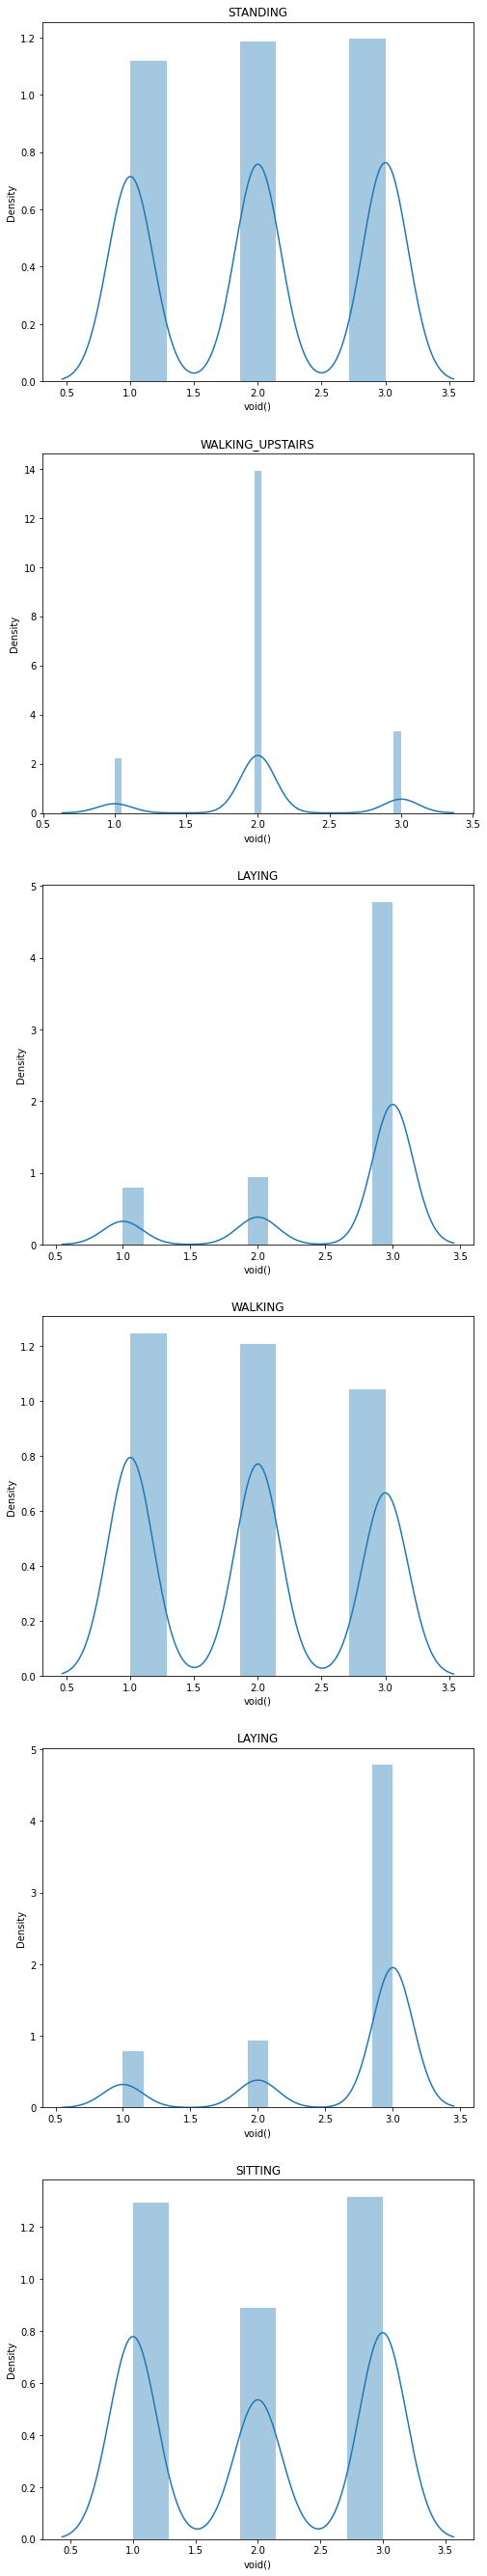

In [12]:
n = df["Activity"].nunique()
fig, ax = plt.subplots(n, 1, figsize=(8, n*8))
for axi, actv in zip(ax, df["Activity"]):
    sns.distplot(df.loc[df["Activity"]==actv, "void()"], ax=axi, kde=True)
    axi.set_title(actv)
    
plt.show()    

In [13]:
X.drop(columns="void()", inplace=True)

In [14]:
# X.drop(columns=['tBodyGyro-low()-X',
#  'tBodyGyro-low()-Z',
#  'tBodyGyro-low()-Y',
#  'fBodyAcc-main()-Y',
#  'fBodyAcc-main()-Z',
#  'fBodyAcc-main()-X',
#  'shadow-gravity-angle()',
#  'energy-mean()'], inplace=True)

In [15]:
a = pd.DataFrame.from_dict(Counter([col.split('-')[0].split('(')[0] for col in X.columns]), orient='index').rename(columns={0:'count'}).sort_values('count', ascending=False)

### Exploratory data analysis

In [16]:
X.isna().sum().sort_values(ascending=False)

fBodyGyro-bandsEnergy()-33,48    84
fBodyAcc-bandsEnergy()-49,56     79
tBodyAccMag-sma()                77
fBodyAccJerk-std()-Y             77
tBodyGyro-std()-X                76
                                 ..
tGravityAccMag-entropy()         41
tGravityAcc-std()-X              40
fBodyAcc-main()-Z                39
fBodyAcc-entropy()-Y             38
subject                           0
Length: 570, dtype: int64

In [17]:
nans_sorted = X.T.isna().sum().sort_values(ascending=False)
nans_sorted[nans_sorted > 0]

3536    40
6796    40
6220    40
5397    40
3036    40
        ..
3236     5
6066     5
6507     5
549      5
8877     4
Length: 1462, dtype: int64

Cardinality

In [18]:
pd.DataFrame(X.nunique().sort_values(ascending=False)).T

,tBodyGyro-low()-Y,energy-mean(),tGravityAccMag-sma(),fBodyAcc-main()-Z,tGravityAccMag-mad(),tBodyAcc-mean()-Z,"tBodyAccJerk-arCoeff()-X,1",fBodyGyro-mad()-Z,fBodyAcc-skewness()-Z,fBodyAccJerk-kurtosis()-X,"tBodyGyro-arCoeff()-Y,2",tBodyGyro-std()-Y,"tBodyGyroJerk-arCoeff()-X,2",fBodyAcc-meanFreq()-Y,"tBodyGyro-correlation()-Y,Z",fBodyGyro-skewness()-Z,fBodyAccJerk-max()-Y,"tGravityAcc-arCoeff()-Z,3",tBodyAcc-sma(),fBodyGyro-iqr()-Y,tBodyAccJerk-mean()-Y,tBodyGyroMag-arCoeff()3,fBodyAccJerk-skewness()-X,fBodyAccMag-mean(),"tBodyAcc-arCoeff()-Z,3","tBodyAcc-correlation()-X,Z",tBodyGyroMag-std(),tBodyAcc-std()-X,"tBodyGyroJerk-arCoeff()-Z,4",fBodyGyro-kurtosis()-X,tBodyAccMag-arCoeff()2,fBodyAcc-kurtosis()-Z,fBodyAcc-mean()-Z,fBodyGyro-mad()-X,"tBodyGyro-arCoeff()-Z,4",fBodyBodyGyroJerkMag-kurtosis(),tBodyAccMag-mean(),"tBodyGyroJerk-arCoeff()-Y,1",tBodyGyroJerk-mean()-X,fBodyAccMag-skewness(),"tBodyGyroJerk-arCoeff()-X,1","tBodyGyro-arCoeff()-Z,1","tBodyAccJerk-correlation()-X,Z",fBodyGyro-max()-Y,tGravityAcc-sma(),fBodyAccJerk-min()-Y,fBodyBodyGyroMag-mad(),fBodyBodyGyroMag-mean(),"tBodyAcc-arCoeff()-X,3",fBodyAccJerk-meanFreq()-Y,"tBodyAccJerk-correlation()-Y,Z",fBodyBodyGyroJerkMag-mad(),tBodyGyroJerkMag-iqr(),fBodyGyro-std()-X,fBodyGyro-meanFreq()-Y,tBodyAcc-iqr()-Z,tBodyGyroJerk-iqr()-Z,fBodyAccJerk-skewness()-Z,tBodyGyroJerk-sma(),tBodyGyroMag-sma(),"angle(Y,gravityMean)","tGravityAcc-correlation()-Y,Z","tBodyAccJerk-arCoeff()-Y,1","tBodyGyro-arCoeff()-X,2","tBodyAccJerk-arCoeff()-Y,3",tBodyGyro-mad()-Y,"tBodyAccJerk-arCoeff()-Z,2","tBodyGyro-arCoeff()-Y,1",fBodyAcc-min()-Z,fBodyAcc-max()-Z,"tBodyGyro-arCoeff()-Z,3",fBodyGyro-meanFreq()-X,tBodyAccJerkMag-iqr(),tBodyAccJerkMag-arCoeff()4,tBodyAcc-mad()-X,tBodyAccJerk-std()-Z,tBodyAccJerk-mean()-X,"tBodyGyroJerk-correlation()-X,Z",tBodyGyro-iqr()-Z,"tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Z,2",tBodyAcc-mad()-Y,shadow-gravity-angle(),tBodyAccMag-iqr(),fBodyBodyGyroMag-sma(),tBodyGyroJerk-std()-Z,tBodyGyroJerkMag-arCoeff()2,tBodyGyroJerkMag-arCoeff()4,fBodyAccJerk-min()-X,tGravityAcc-mean()-X,fBodyBodyGyroJerkMag-skewness(),fBodyAccJerk-meanFreq()-Z,"tGravityAcc-arCoeff()-Z,2",tBodyAcc-mean()-Y,tGravityAcc-std()-X,fBodyAcc-min()-Y,tBodyAccJerk-mad()-Y,fBodyGyro-mean()-X,tBodyAcc-std()-Y,tBodyGyroMag-mean(),tBodyGyro-mad()-X,tBodyGyro-mean()-Z,tBodyGyro-mean()-X,tGravityAcc-energy()-X,tGravityAcc-energy()-Z,tBodyGyro-mad()-Z,tGravityAccMag-arCoeff()1,"tBodyGyro-arCoeff()-Y,3",fBodyBodyGyroMag-meanFreq(),tBodyGyroJerkMag-arCoeff()1,"angle(Z,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)",fBodyGyro-iqr()-X,fBodyGyro-std()-Z,tBodyAccJerkMag-sma(),"tBodyAcc-arCoeff()-X,2",fBodyBodyGyroMag-skewness(),"tBodyAccJerk-arCoeff()-Z,1",fBodyBodyGyroMag-kurtosis(),tBodyAcc-iqr()-X,"tBodyGyroJerk-correlation()-Y,Z",tBodyAccJerk-iqr()-Y,fBodyAcc-iqr()-Z,tGravityAcc-iqr()-Z,fBodyAcc-std()-X,"tBodyAccJerk-arCoeff()-Z,3","tBodyGyro-arCoeff()-X,4",tBodyAccJerk-mean()-Z,fBodyAcc-iqr()-Y,fBodyAcc-mad()-Z,fBodyAcc-mad()-Y,fBodyAccJerk-iqr()-Y,fBodyGyro-max()-X,"tBodyAccJerk-arCoeff()-X,3",fBodyBodyAccJerkMag-max(),fBodyGyro-meanFreq()-Z,fBodyBodyGyroJerkMag-min(),fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-max(),fBodyBodyAccJerkMag-skewness(),"tBodyGyroJerk-arCoeff()-Z,2",tBodyAcc-mad()-Z,"tBodyAccJerk-arCoeff()-X,2","tBodyGyroJerk-arCoeff()-Y,2","tGravityAcc-arCoeff()-X,3",fBodyBodyAccJerkMag-mean(),"tBodyGyroJerk-arCoeff()-X,3",fBodyAccMag-meanFreq(),fBodyAccJerk-min()-Z,tBodyGyro-std()-Z,fBodyBodyAccJerkMag-iqr(),fBodyAccMag-mad(),fBodyGyro-mad()-Y,fBodyBodyGyroJerkMag-meanFreq(),fBodyGyro-min()-Y,fBodyBodyGyroMag-std(),fBodyAccJerk-mean()-X,fBodyAcc-kurtosis()-Y,fBodyAcc-mad()-X,"tBodyAccJerk-correlation()-X,Y",fBodyAccJerk-kurtosis()-Y,tBodyAccJerkMag-arCoeff()3,tBodyAcc-std()-Z,tGravityAccMag-std(),"tBodyGyroJerk-arCoeff()-X,4",tGravityAcc-std()-Y,tGravityAcc-mad()-Y,tBodyGyro-low()-X,"tBodyGyro-correlation()-X,Z",tGravityAccMag-iqr(),"tGravityAcc-arCoeff()-Z,4",tBodyGyro-mean()

### Subjects checkout

In [19]:
X["subject"].nunique()

30

In [20]:
X.nunique().sort_values(ascending=True)

fBodyAcc-maxInds-Y            23
fBodyAcc-maxInds-Z            25
fBodyGyro-maxInds-Z           25
fBodyGyro-maxInds-X           26
fBodyBodyGyroMag-maxInds      27
                            ... 
tGravityAccMag-mad()        8577
fBodyAcc-main()-Z           8599
tGravityAccMag-sma()        8615
energy-mean()               8776
tBodyGyro-low()-Y           8793
Length: 570, dtype: int64

### Plot activity on number of occurances per subject 

In [21]:
subjects_count = df[["subject","Activity"]].groupby(["subject"]).count().reset_index()

In [22]:
subjects_groups = df[["subject","Activity", "energy-mean()" ]].groupby(["subject", "Activity"]).count().reset_index()

In [23]:
activities_subjects = df[["subject","Activity"]].groupby(["Activity"]).count().reset_index()

In [24]:
subjects_groups

,subject,Activity,energy-mean()
0,1,LAYING,19
1,1,SITTING,50
2,1,STANDING,42
3,1,WALKING,103
4,1,WALKING_DOWNSTAIRS,55
...,...,...,...
175,30,SITTING,60
176,30,STANDING,44
177,30,WALKING,67
178,30,WALKING_DOWNSTAIRS,69


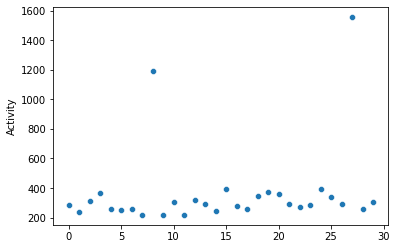

In [25]:
subjects_sorted = subjects_count.sort_index()
sns.scatterplot(data=subjects_sorted["Activity"])
plt.show()

In [26]:
subjects_groups["subject"].nunique()

30

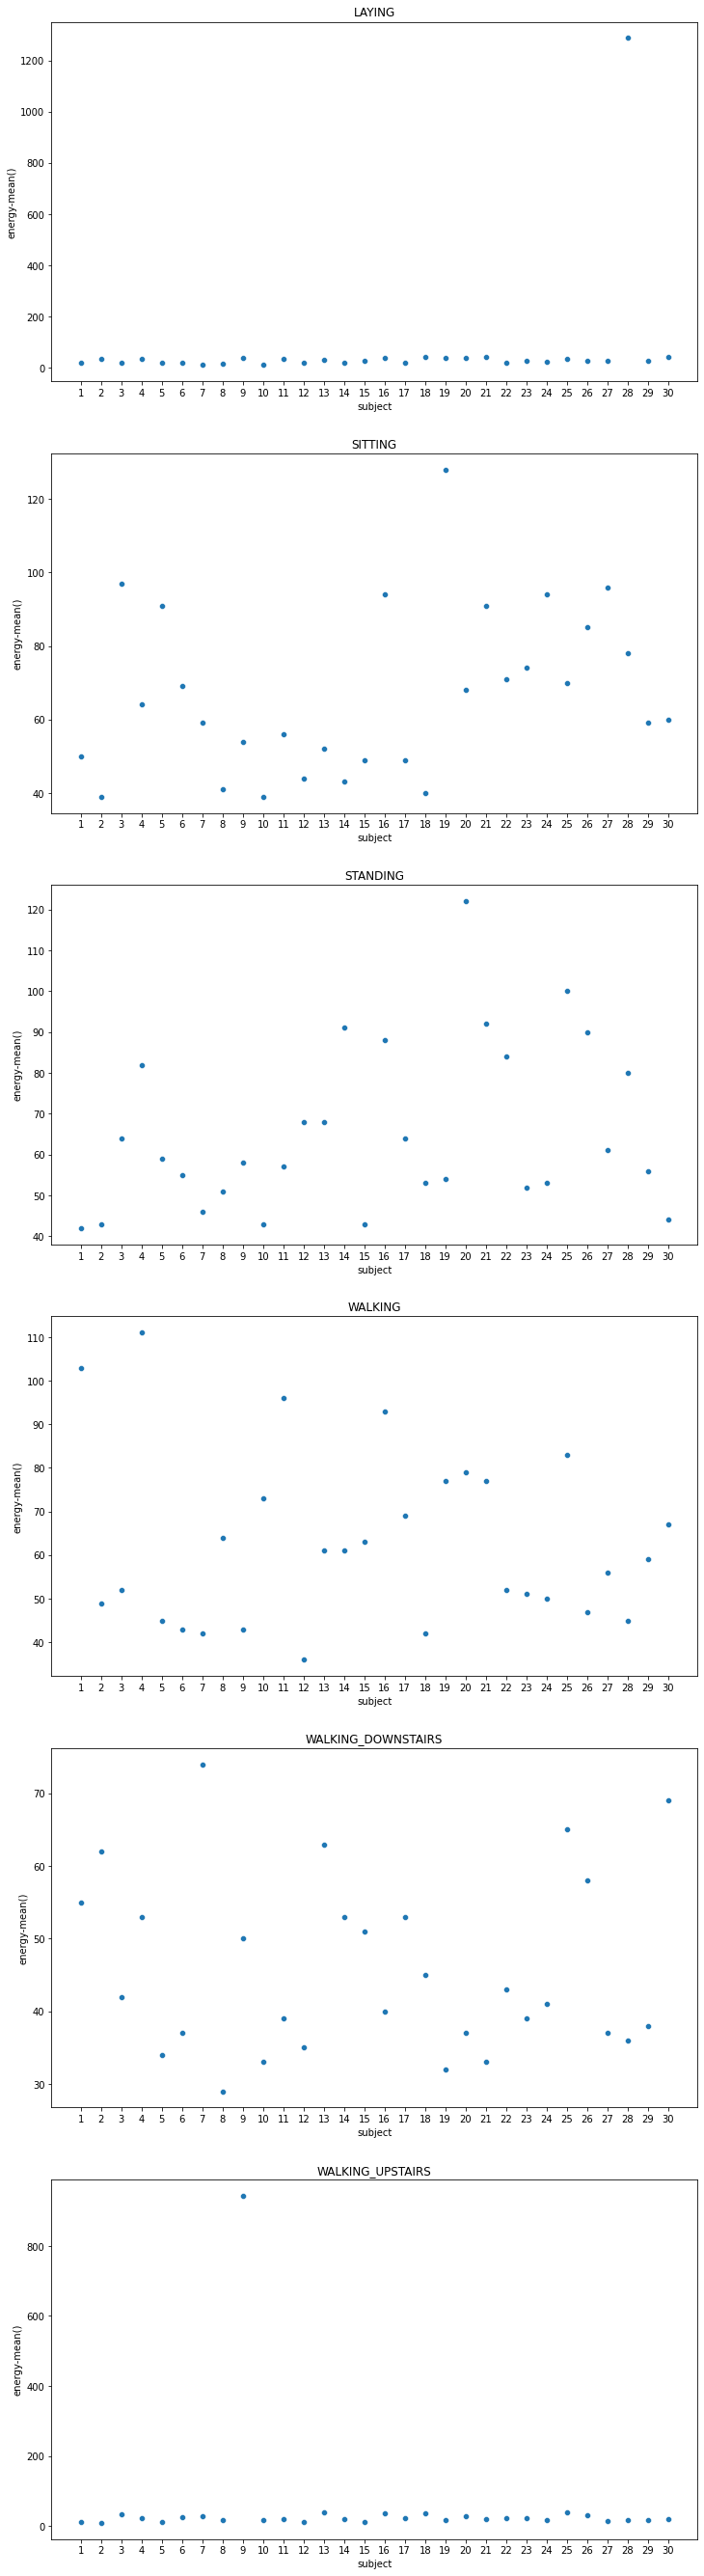

In [27]:
n = len(subjects_groups["Activity"].unique())

fix, ax = plt.subplots(n, 1, figsize=(12, len(subjects_groups["Activity"].unique())*8))

for axi, activity in zip(ax, subjects_groups["Activity"].unique()):
    sns.scatterplot(x="subject", y="energy-mean()", data=subjects_groups[subjects_groups["Activity"]==activity], ax=axi)
    axi.set_xticks(np.arange(1, subjects_groups["subject"].nunique()+1))
    axi.set_title(activity)

plt.show()

In [28]:
subjects_groups

,subject,Activity,energy-mean()
0,1,LAYING,19
1,1,SITTING,50
2,1,STANDING,42
3,1,WALKING,103
4,1,WALKING_DOWNSTAIRS,55
...,...,...,...
175,30,SITTING,60
176,30,STANDING,44
177,30,WALKING,67
178,30,WALKING_DOWNSTAIRS,69


### Data preprocessing

In [29]:
persons = df['subject'].unique().tolist()

In [30]:
subject = df['subject']
target = y
df = X

### Scaling and imputing
Converting 3 coordinate system columns to euclidean distance

In [31]:
for person in persons:       
    imputer = KNNImputer(n_neighbors=5) 
    df[df['subject']==person] = imputer.fit_transform(df[df['subject']==person])

# xyz_bands_energy = np.array(sorted([column for column in df.columns if "bandsEnergy" in column])).reshape(-1, 3)
# for xyz in xyz_bands_energy:
#     df[f"{xyz[0]}_euclid"] = (df[xyz] ** 2).sum(axis=1)
#     df.drop(columns=xyz, inplace=True)

for person in persons:   
    scaler = StandardScaler()
    df[df['subject']==person] = scaler.fit_transform(df[df['subject']==person])

In [32]:
df['subject'] = subject

In [33]:
y = target
X = df

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 444)

In [35]:
X_train.shape, X_test.shape

((7682, 570), (3293, 570))

### Catboost

In [36]:
cat_features = ["subject"]

In [37]:
X_train["subject"], X_test["subject"] = X_train["subject"].astype("int8"), X_test["subject"].astype("int8")

In [38]:
classifier = catboost.CatBoostClassifier(
    task_type="GPU", 
    devices="0",
    iterations=7000,
    metric_period=500,
)

In [39]:
classifier.fit(X_train, y_train, cat_features=cat_features, verbose=1)

Learning rate set to 0.019452
0:	learn: 1.7492694	total: 19.3ms	remaining: 2m 14s
500:	learn: 0.0575079	total: 7.3s	remaining: 1m 34s
1000:	learn: 0.0265107	total: 14.3s	remaining: 1m 25s
1500:	learn: 0.0163318	total: 21.3s	remaining: 1m 17s
2000:	learn: 0.0111365	total: 28.2s	remaining: 1m 10s
2500:	learn: 0.0081648	total: 35.1s	remaining: 1m 3s
3000:	learn: 0.0063243	total: 42s	remaining: 56s
3500:	learn: 0.0050456	total: 49s	remaining: 49s
4000:	learn: 0.0041853	total: 56s	remaining: 42s
4500:	learn: 0.0035465	total: 1m 2s	remaining: 35s
5000:	learn: 0.0030785	total: 1m 9s	remaining: 27.9s
5500:	learn: 0.0026761	total: 1m 16s	remaining: 20.9s
6000:	learn: 0.0023686	total: 1m 23s	remaining: 13.9s
6500:	learn: 0.0021155	total: 1m 30s	remaining: 6.96s
6999:	learn: 0.0019055	total: 1m 37s	remaining: 0us


In [40]:
y_hat = classifier.predict(X_test)

In [41]:
accuracy_score(y_test, y_hat)

0.9972669298511995

### Final explaination

In [42]:
X["subject"] = X["subject"].astype("int8")

In [43]:
def perform_cross_validation(classifier, X_train, y_train, cv=5):
    scores = cross_val_score(classifier, X_train, y_train, cv=cv)
    return scores

In [44]:
classifier_v2 = catboost.CatBoostClassifier(
    task_type="GPU", 
    devices="0",
    iterations=7000,
    metric_period=500,
)

In [45]:
cv_scores = perform_cross_validation(classifier=classifier_v2, X_train=X, y_train=y, cv=5)

Learning rate set to 0.019989
0:	learn: 1.7165471	total: 13.6ms	remaining: 1m 35s
500:	learn: 0.0555277	total: 5.11s	remaining: 1m 6s
1000:	learn: 0.0255578	total: 10s	remaining: 1m
1500:	learn: 0.0157190	total: 14.9s	remaining: 54.6s
2000:	learn: 0.0107690	total: 19.8s	remaining: 49.4s
2500:	learn: 0.0079123	total: 24.6s	remaining: 44.3s
3000:	learn: 0.0061241	total: 29.6s	remaining: 39.4s
3500:	learn: 0.0049402	total: 34.5s	remaining: 34.5s
4000:	learn: 0.0040689	total: 39.5s	remaining: 29.6s
4500:	learn: 0.0034233	total: 44.4s	remaining: 24.6s
5000:	learn: 0.0029413	total: 49.3s	remaining: 19.7s
5500:	learn: 0.0025618	total: 54.3s	remaining: 14.8s
6000:	learn: 0.0022752	total: 59.2s	remaining: 9.85s
6500:	learn: 0.0020489	total: 1m 4s	remaining: 4.92s
6999:	learn: 0.0018516	total: 1m 8s	remaining: 0us
Learning rate set to 0.019989
0:	learn: 1.7162833	total: 13.9ms	remaining: 1m 37s
500:	learn: 0.0548346	total: 5.18s	remaining: 1m 7s
1000:	learn: 0.0256364	total: 10.2s	remaining: 1m 

In [46]:
cv_scores

array([0.99863326, 0.99817768, 0.99681093, 0.9977221 , 0.99589977])

In [47]:
np.mean(cv_scores)

0.9974487471526196

In [48]:
def plot_importance(catboost_model, column_names, cols_num=20):
    """
    Function created for cotboost models to visualize feature importance. 
    It shows X most important features.
    """
    important_df = pd.DataFrame()
    important_df['feature'] = column_names
    important_df['importance'] = catboost_model.get_feature_importance()
    df_to_plot = important_df.sort_values(
        by='importance', 
        ascending=False).reset_index(drop=True).head(cols_num)
    fig = plt.figure(figsize=(17,cols_num))
    axes = fig.subplots(ncols=1, nrows=int(cols_num/5), sharey=True)
    ax_counter = 0
    for i in range(0, cols_num, 5):
        sns.barplot(df_to_plot['feature'][i:i+5],
                    df_to_plot['importance'][i:i+5], ax=axes[ax_counter])  
        ax_counter += 1
    
    for ax in axes:
        for p in ax.patches:
            ax.annotate(str(round(p.get_height(),2)), 
                        (p.get_x() * 1.005, p.get_height() * 1.01))

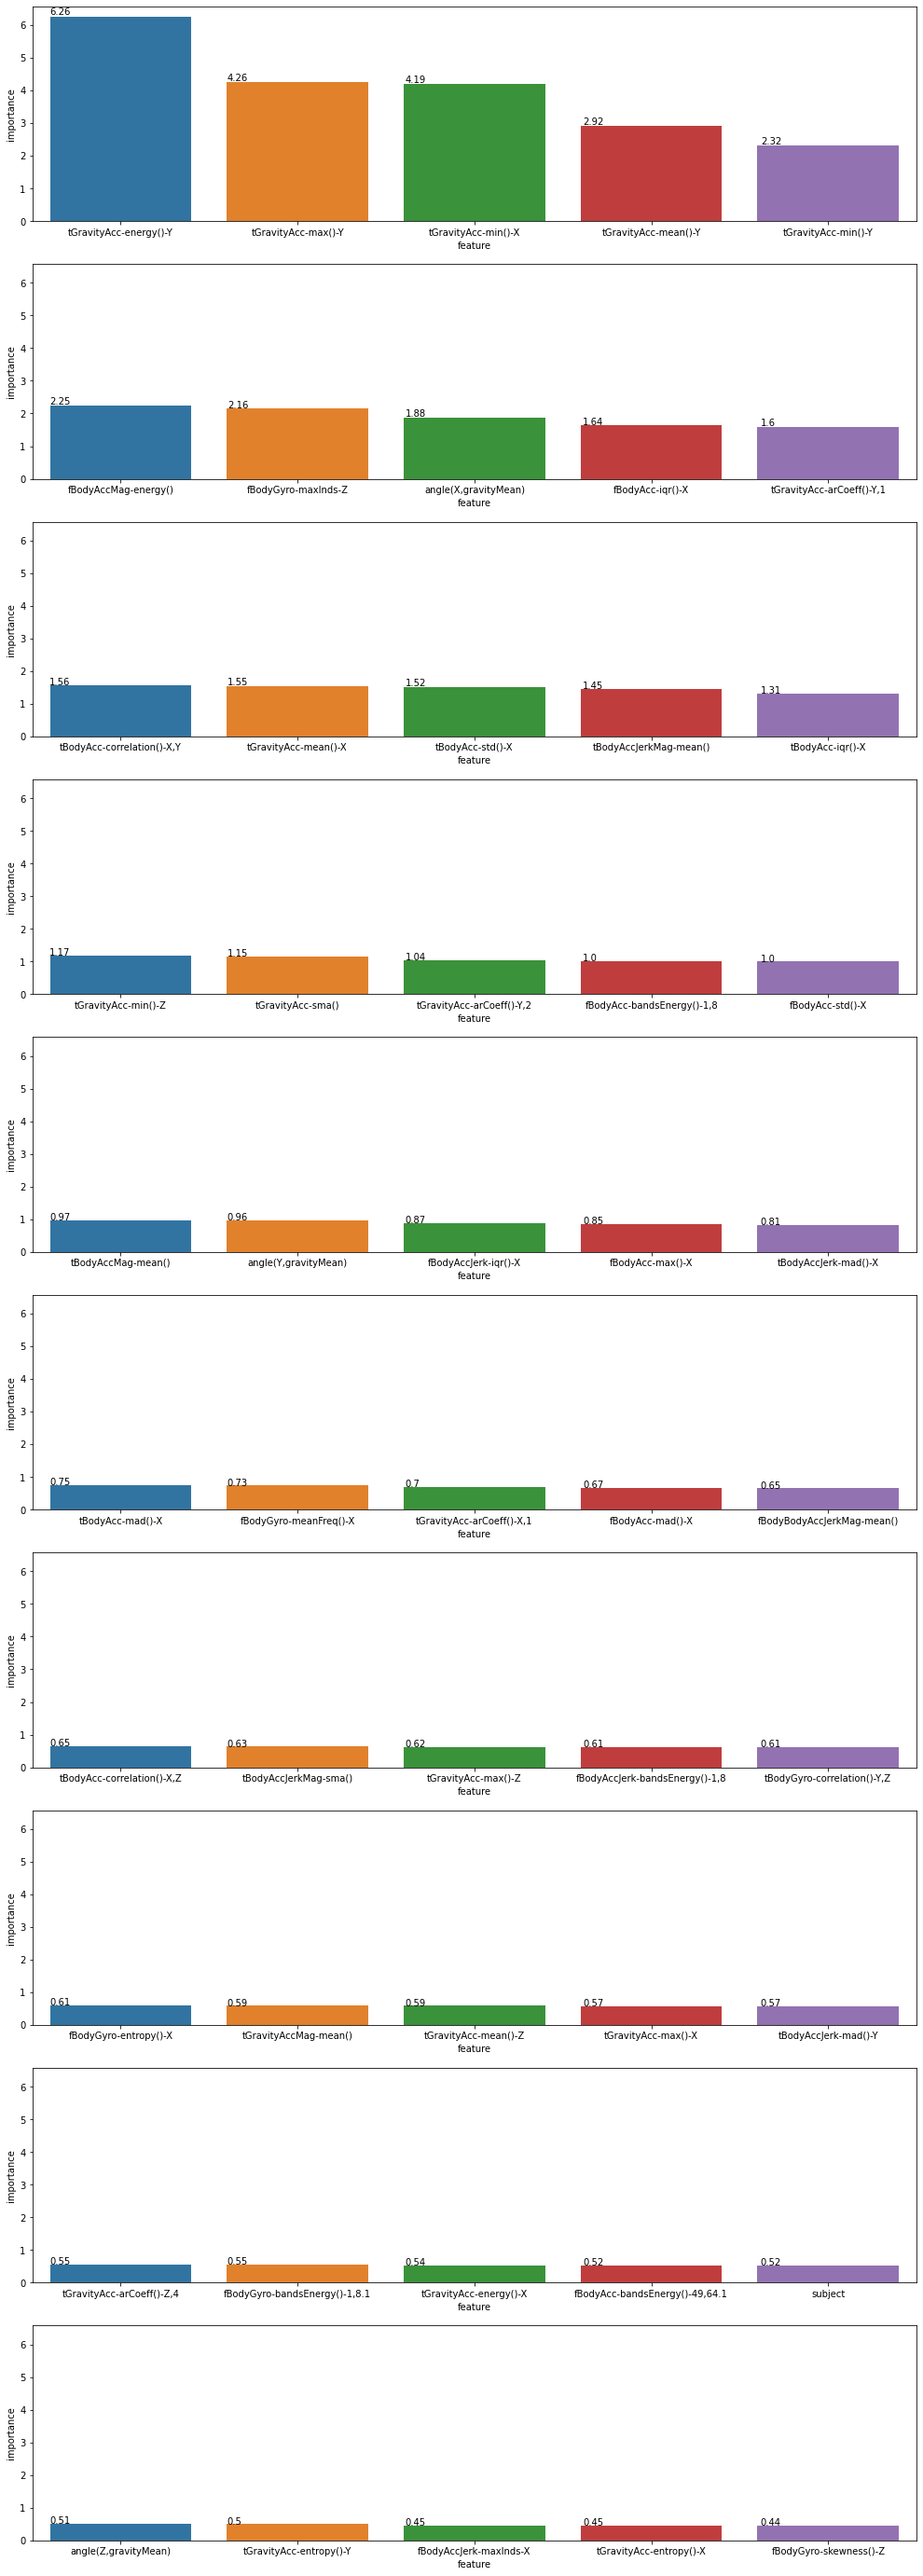

In [49]:
plot_importance(classifier, X.columns.tolist(), cols_num=50)

In [50]:
labels = list(target.unique())

In [51]:
def get_model_score_metrics(labels, y_test, y_pred):
    # accuracy for whole validation set 
    model_accuracy = accuracy_score(y_test, y_pred)
    # metrics indicating model performance for particural classes
    pr_rec_f_supp = precision_recall_fscore_support(y_test, y_pred)
    df_report = pd.DataFrame({'Precision':list(pr_rec_f_supp[0]),
                              'Recall':list(pr_rec_f_supp[1]),
                              'F-Score':list(pr_rec_f_supp[2]),
                              'Support':list(pr_rec_f_supp[3])}, index=labels)
    return model_accuracy, df_report

In [52]:
acc, performance_per_class = get_model_score_metrics(labels=labels, y_test=y_test, y_pred=y_hat)

In [53]:
acc

0.9972669298511995

In [54]:
performance_per_class

,Precision,Recall,F-Score,Support
STANDING,1.000000,1.000000,1.000000,650
WALKING_UPSTAIRS,0.998316,0.991639,0.994966,598
LAYING,0.991197,0.998227,0.994700,564
WALKING,0.998217,0.998217,0.998217,561
SITTING,0.997653,1.000000,0.998825,425
WALKING_DOWNSTAIRS,0.997976,0.995960,0.996967,495


In [55]:
important_df = pd.DataFrame()
important_df['feature'] = X_train.columns.tolist()
important_df['importance'] = classifier.get_feature_importance()

In [56]:
# BodyGyro
sum(important_df['importance'][important_df['feature'].str.match(r'(.*)BodyGyro(.*)')==True])

18.877673128654354

In [57]:
# BodyAcc
sum(important_df['importance'][important_df['feature'].str.match(r'(.*)BodyAcc(.*)')==True])

41.23092786428403

### Confusion matrix

In [58]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [59]:
confusion_matrix(y_test, y_hat)

array([[650,   0,   0,   0,   0,   0],
       [  0, 593,   5,   0,   0,   0],
       [  0,   1, 563,   0,   0,   0],
       [  0,   0,   0, 560,   0,   1],
       [  0,   0,   0,   0, 425,   0],
       [  0,   0,   0,   1,   1, 493]])

In [60]:
mapping = {cat:idx for idx, cat in enumerate(target.unique())}
mapping

{'STANDING': 0,
 'WALKING_UPSTAIRS': 1,
 'LAYING': 2,
 'WALKING': 3,
 'SITTING': 4,
 'WALKING_DOWNSTAIRS': 5}

Confusion matrix, without normalization
Normalized confusion matrix


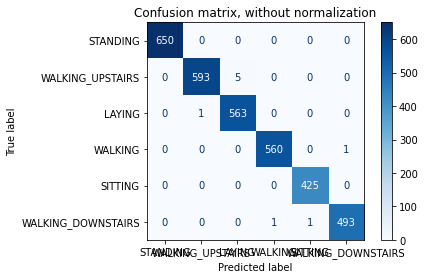

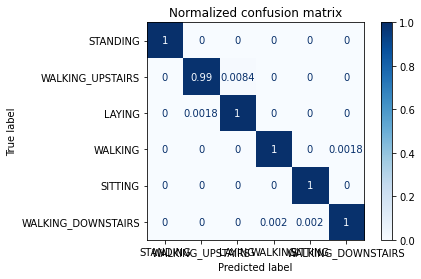

In [61]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 display_labels=mapping.keys(),
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
#     print(disp.confusion_matrix)

plt.show()

### AUROC

In [62]:
y_test_dummy = pd.get_dummies(y_test)[mapping.keys()]
y_hat_dummy = pd.get_dummies(y_hat.flatten())[mapping.keys()]

In [63]:
y_hat_dummy.index = y_test_dummy.index
y_test_dummy = y_test_dummy.sort_index()
y_hat_dummy = y_hat_dummy.sort_index()

In [64]:
y_test
y_hat
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y.nunique()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_dummy.iloc[:, i], y_hat_dummy.iloc[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_dummy.values.ravel(), y_hat_dummy.values.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

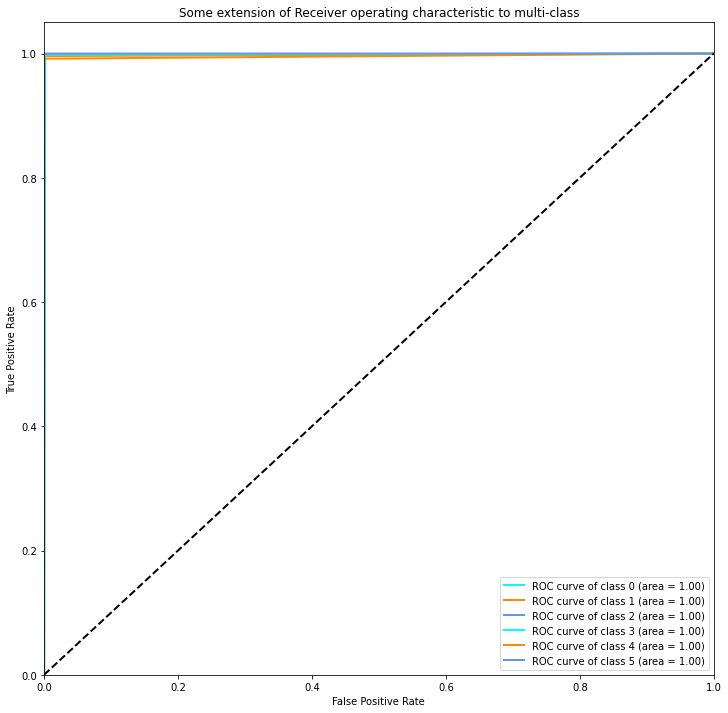

In [65]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

lw=2
# Plot all ROC curves
plt.figure(figsize=(12,12))
# plt.plot(fpr["micro"], tpr["micro"],
#          label='micro-average ROC curve (area = {0:0.2f})'
#                ''.format(roc_auc["micro"]),
#          color='deeppink', linestyle=':', linewidth=4)

# plt.plot(fpr["macro"], tpr["macro"],
#          label='macro-average ROC curve (area = {0:0.2f})'
#                ''.format(roc_auc["macro"]),
#          color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [68]:
roc_auc

{0: 0.9981973886987414,
 1: 0.9978010989090331,
 2: 1.0,
 3: 0.9989257182974347,
 4: 0.9956338692363537,
 5: 0.9998256624825663,
 'micro': 0.9983601579107196,
 'macro': 0.9983972896040215}

### Model save point

In [66]:
filename = 'final_cat2.pickle'
pickle.dump(classifier, open(filename, 'wb'))